In [1]:
#! kaggle datasets download uraninjo/augmented-alzheimer-mri-datasetm

###https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset-v2

**In this NoteBook**, a convolutional neural network (CNN)-based Alzheimer MRI images classification algorithm is developed using **ResNet152V2** architecture, to detect **"Mild Demented"**, **"Moderate Demented"**, **"Non Demented"** and **"Very Mild Demented"** in patient's MRI.

In [2]:
import os
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import applications
from PIL import Image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import plot_loss_curves

--2023-08-31 00:09:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-31 00:09:06 (115 MB/s) - ‘helper_functions.py’ saved [10246/10246]



#  Uploading the Data

In [5]:
########### splitting data ############
%pip install split-folders
import splitfolders
splitfolders.ratio('..///content/drive/MyDrive/Dataset', output="input", seed=1345, ratio=(0.7,0.3,0))

SAMPLE_PER_CATEGORY = 200
SEED = 42
WIDTH = 128
HEIGHT = 128
DEPTH = 3
INPUT_SHAPE = (WIDTH, HEIGHT, DEPTH)
data_dir = '..///content/input'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'val')

Copying files: 6400 files [03:11, 33.35 files/s] 


**Mathematical model for Hyper param tuning**

In [6]:
import numpy as np
from scipy.optimize import minimize
# Objective Function
def objective_function(params, target_accuracy):
    epochs, iterations, batch_size, dropout_factor = params
    return -target_accuracy / (epochs * iterations * batch_size * (1 - dropout_factor))
# Example optimization
def optimize_params(target_accuracy, input_size):
    # Bounds for each parameter: (epochs, iterations, batch_size, dropout_factor)
    bounds = [(1, 100), (1, 1000), (1, 128), (0.0, 0.99)]
    # Initial guess for the parameters: (epochs, iterations, batch_size, dropout_factor)
    initial_guess = [10, 100, 64, 0.1]
    # Perform optimization using scipy's minimize function
    result = minimize(objective_function, initial_guess, args=(target_accuracy,),
                      bounds=bounds, method='SLSQP')
    # Get the optimized parameters
    epochs, iterations, batch_size, dropout_factor = result.x

    return epochs, iterations, batch_size, dropout_factor
if __name__ == "__main__":
    # Example input size and target accuracy
    input_size = 34004
    target_accuracy = 0.99
    # Optimize parameters
    epochs, iterations, batch_size, dropout_factor = optimize_params(target_accuracy, input_size)
    print("Optimized Parameters:")
    print(f"Number of Epochs: {int(epochs)}")
    print(f"Number of Iterations per Epoch: {int(iterations)}")
    print(f"Batch Size: {int(batch_size)}")
    print(f"Dropout Factor: {dropout_factor:.2f}")


Optimized Parameters:
Number of Epochs: 10
Number of Iterations per Epoch: 100
Batch Size: 64
Dropout Factor: 0.10


# Defining Categories

In [7]:
CATEGORIES = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
NUM_CATEGORIES = len(CATEGORIES)
NUM_CATEGORIES

4

### Calculating the number of images in each category in training data

In [8]:
for category in CATEGORIES:
  print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Mild_Demented 627 images
Moderate_Demented 44 images
Non_Demented 2240 images
Very_Mild_Demented 1568 images


# Creating Train and Validation DataFrame

In [9]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.shape

(4479, 3)

In [10]:
train = train.sample(frac=1)
X = train.drop(columns = 'category_id')
y = train['category_id']

In [11]:
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=4) ###### train size from 0.2 to 0.3

In [12]:
train = pd.concat([x_train, y_train], axis=1)
validation = pd.concat([x_valid, y_valid], axis=1)

In [13]:
train = train.reset_index()
train = train.drop(columns = 'index')
validation = validation.reset_index()
validation = validation.drop(columns = 'index')
print(train.shape)
print(validation.shape)

(3135, 3)
(1344, 3)


In [14]:
train.head()

,file,category,category_id
0,train/Non_Demented/non_282.jpg,Non_Demented,2
1,train/Non_Demented/non_2009.jpg,Non_Demented,2
2,train/Mild_Demented/mild_126.jpg,Mild_Demented,0
3,train/Non_Demented/non_1361.jpg,Non_Demented,2
4,train/Non_Demented/non_63.jpg,Non_Demented,2


In [15]:
validation.head()

,file,category,category_id
0,train/Very_Mild_Demented/verymild_244.jpg,Very_Mild_Demented,3
1,train/Very_Mild_Demented/verymild_1621.jpg,Very_Mild_Demented,3
2,train/Very_Mild_Demented/verymild_1990.jpg,Very_Mild_Demented,3
3,train/Non_Demented/non_1589.jpg,Non_Demented,2
4,train/Very_Mild_Demented/verymild_1930.jpg,Very_Mild_Demented,3


# Creating Test DataFrame

In [16]:
test = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(test_dir, category)):
        test.append(['val/{}/{}'.format(category, file), category_id, category])
test = pd.DataFrame(test, columns=['file', 'category_id', 'category'])
test.shape

(1919, 3)

# Demonstrating Example Images

In [17]:
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

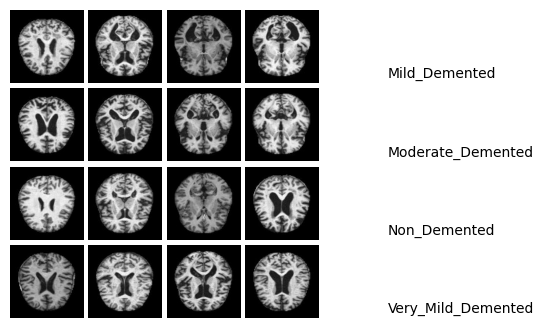

In [18]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)

i=0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (WIDTH, HEIGHT))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i+=1

plt.show();

# Keras ImageDataGenerator

In [19]:
datagen_train = ImageDataGenerator(rescale=1./255)
train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="..///content/input",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32, # from 32 to 64
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

validation_generator = datagen_train.flow_from_dataframe(dataframe=validation,
                                                  directory="..///content/input",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32, # from 32 to 64
                                                  seed=SEED,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 3135 validated image filenames belonging to 4 classes.
Found 1344 validated image filenames belonging to 4 classes.


In [20]:
datagen_test = ImageDataGenerator(rescale=1./255)
test_generator = datagen_test.flow_from_dataframe(dataframe=test,
                                                  directory="..///content/input",
                                                  x_col="file",
                                                  y_col="category",
                                                  batch_size=32, # from 32 to 64
                                                  seed=SEED,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(HEIGHT, WIDTH));

Found 1919 validated image filenames belonging to 4 classes.


## Early Stopping

In [21]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

###Creating CallBacks   ===> 8-8-2023

In [22]:
# Hyperparameter Tuning ===>   8-8-2023
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

# Creating Model based on ResNet152V2

In [23]:
def create_model():

    resnet_model = tf.keras.applications.resnet_v2.ResNet152V2(
        weights='imagenet',
        include_top = False,
        input_shape = (224, 224, 3)
    )

    for layers in resnet_model.layers[:100]:
        layers.trainable = False
    for layers in resnet_model.layers[100:]:
        layers.trainable = True

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.2)(x)  # from 0.2 to 0.1
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # from 0.2 to 0.1
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)  # from 0.2 to 0.1
    # output layer
    predictions = tf.keras.layers.Dense(4, activation='softmax')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    optimizer = tf.keras.optimizers.RMSprop()
    #optimizer = tf.keras.optimizers.SGD()
    #optimizer = tf.keras.optimizers.RMSprop()
    #res_model.compile(loss='categorical_crossentropy', optimizer='ٌadam', metrics=['accuracy'])
    res_model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])
    return res_model

In [24]:
res_model = create_model()

234545216/234545216 [==============================] - 12s 0us/step


In [25]:
res_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [26]:
# Model Architecture Visualization
tf.keras.utils.plot_model(res_model, to_file='resnet152v2.png', show_shapes=True, show_layer_names=True)

Output hidden; open in https://colab.research.google.com to view.

# Training the Model

In [27]:
history = res_model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=50,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    callbacks=callbacks,
                    batch_size=32,
                    verbose=1)

Epoch 1/50
98/98 [==============================] - 122s 352ms/step - loss: 1.0814 - accuracy: 0.4957 - val_loss: 22.4307 - val_accuracy: 0.5082 - lr: 0.0010
Epoch 2/50
98/98 [==============================] - 28s 288ms/step - loss: 0.7992 - accuracy: 0.6517 - val_loss: 32.6843 - val_accuracy: 0.5298 - lr: 0.0010
Epoch 3/50
98/98 [==============================] - 31s 316ms/step - loss: 0.5923 - accuracy: 0.7563 - val_loss: 7.1604 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 4/50
98/98 [==============================] - 29s 296ms/step - loss: 0.4120 - accuracy: 0.8402 - val_loss: 3.4818 - val_accuracy: 0.7374 - lr: 0.0010
Epoch 5/50
98/98 [==============================] - 27s 272ms/step - loss: 0.3057 - accuracy: 0.8842 - val_loss: 4.3794 - val_accuracy: 0.6778 - lr: 0.0010
Epoch 6/50
98/98 [==============================] - 30s 309ms/step - loss: 0.2192 - accuracy: 0.9177 - val_loss: 2.3892 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 7/50
98/98 [==============================] - 31s 317ms

# Plotting the history of model

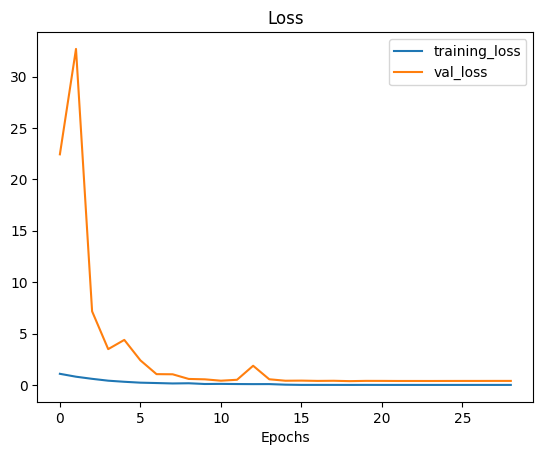

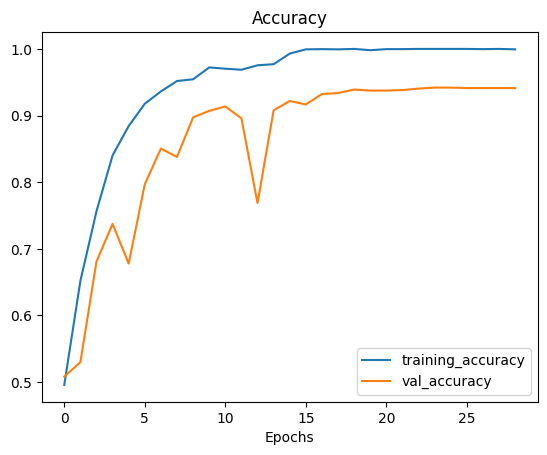

In [28]:
plot_loss_curves(history)

# Evaluation

In [29]:
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

42/42 [==============================] - 4s 83ms/step - loss: 0.3682 - accuracy: 0.9390

Train loss: 0.37
Train Accuracy: 93.90 %


In [30]:
loss, accuracy = res_model.evaluate(test_generator)

print(f'\nTest loss: {loss:.2f} ')
print(f'Test Accuracy: {accuracy*100:.2f} %')

60/60 [==============================] - 5s 86ms/step - loss: 0.3804 - accuracy: 0.9380

Test loss: 0.38 
Test Accuracy: 93.80 %


In [31]:
y_predict = res_model.predict(test_generator)
prediction = np.argmax(y_predict,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
prediction = [labels[k] for k in prediction]

y_test = list(test.category)

report = classification_report(y_test, prediction, output_dict=True)
df = pd.DataFrame(report).transpose()
df

60/60 [==============================] - 7s 78ms/step


,precision,recall,f1-score,support
Mild_Demented,0.948207,0.888060,0.917148,268.000000
Moderate_Demented,0.818182,0.947368,0.878049,19.000000
Non_Demented,0.953271,0.956250,0.954758,960.000000
Very_Mild_Demented,0.916545,0.931548,0.923985,672.000000
accuracy,0.937989,0.937989,0.937989,0.937989
macro avg,0.909051,0.930806,0.918485,1919.000000
weighted avg,0.938365,0.937989,0.937970,1919.000000


####Create the Confusion Matrix

60/60 [==============================] - 5s 79ms/step
Confusion Matrix:
[[238   0   7  23]
 [  0  18   0   1]
 [  7   2 918  33]
 [  6   2  38 626]]


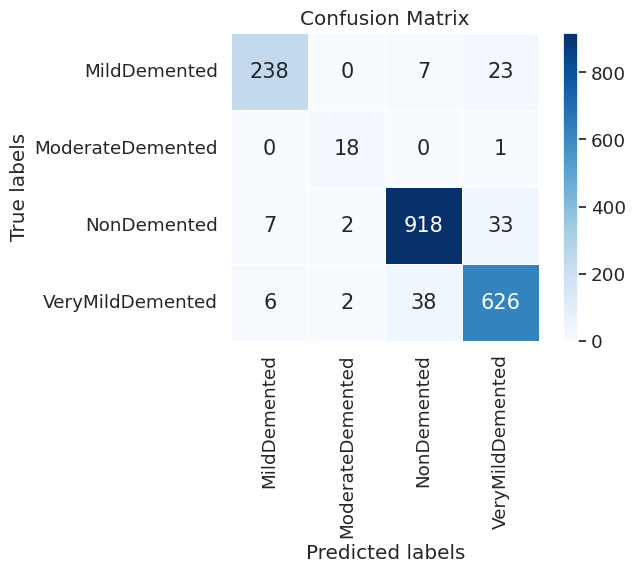

In [32]:
from sklearn.metrics import confusion_matrix
# Set the number of classes for your task
num_classes = 4

# Generate predictions on the test dataset
y_true = test_generator.classes
y_pred = res_model.predict(test_generator)

# Get predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False,
            annot_kws={"size": 15}, linewidths=0.5, square=True,
            xticklabels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], yticklabels=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'])

# Plot confusion matrix
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()


In [33]:
# Evaluate the Model on Test Data   ======>9-8-2023
test_loss, test_accuracy = res_model.evaluate(test_generator, steps=len(test_generator))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


60/60 [==============================] - 5s 82ms/step - loss: 0.3804 - accuracy: 0.9380
Test Loss: 0.3804066777229309
Test Accuracy: 0.9379885196685791


In [34]:
# Evaluate the Model on Train Data   ======>9-8-2023
valid_loss, valid_accuracy = res_model.evaluate(validation_generator)

print(f'\nTrain loss: {valid_loss:.2f}')
print(f'Train Accuracy: {valid_accuracy*100:.2f} %')

42/42 [==============================] - 4s 84ms/step - loss: 0.3682 - accuracy: 0.9390

Train loss: 0.37
Train Accuracy: 93.90 %


"\n# Compute and Plot ROC Curves\ny_true = test_generator.classes\ny_pred = res_model.predict(test_generator)\nfpr = dict()\ntpr = dict()\nroc_auc = dict()\nfor i in range(4):\n    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\nplt.subplot(1, 2, 2)\nplt.plot([0, 1], [0, 1], 'k--')\nfor i in range(4):\n    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\nplt.title('ROC Curves')\nplt.legend()\n\nplt.tight_layout()\nplt.show()\n"

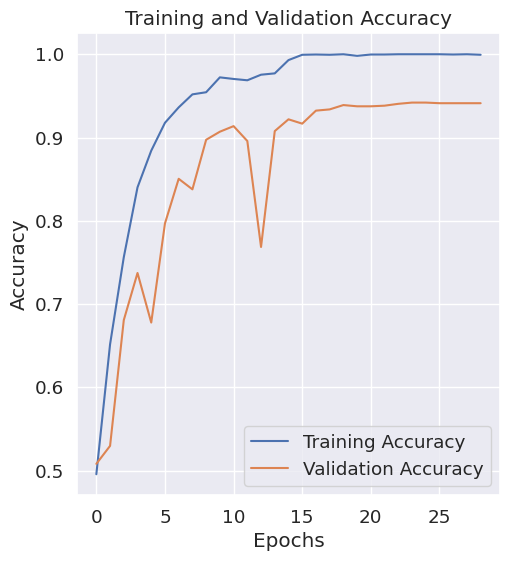

In [35]:
# Metrics Visualization    =====>9-8-2023
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
'''
# Compute and Plot ROC Curves
y_true = test_generator.classes
y_pred = res_model.predict(test_generator)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.subplot(1, 2, 2)
plt.plot([0, 1], [0, 1], 'k--')
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()

plt.tight_layout()
plt.show()
'''

In [36]:
res_model.save('Resnet_model.h5')

In [37]:
!zip -r dowinloadme.zip Resnet_model.h5

  adding: Resnet_model.h5 (deflated 9%)
